In [1]:
import numpy as np
import cupy as cp
from cupyx.scipy.signal import convolve2d, correlate2d

def solve_l1_cupy(v, lam):
    """Anisotropic ℓ₁ shrinkage on GPU."""
    return cp.sign(v) * cp.maximum(cp.abs(v) - lam, 0)

def solve_iso_cupy(v_v, v_h, lam):
    """Isotropic ℓ₂ shrinkage on GPU for paired (v_v, v_h)."""
    norms  = cp.sqrt(v_v**2 + v_h**2)
    shrink = cp.maximum(norms - lam, 0) / cp.maximum(norms, 1e-6)
    return v_v * shrink, v_h * shrink

def Dv_cupy(X):
    dv = cp.empty_like(X)
    dv[:-1, :] = X[1:, :] - X[:-1, :]
    dv[-1, :]  = 0
    return dv

def Dh_cupy(X):
    dh = cp.empty_like(X)
    dh[:, :-1] = X[:, 1:] - X[:, :-1]
    dh[:, -1]  = 0
    return dh

def div_cupy(Pv, Ph):
    m, n = Pv.shape
    dv = cp.empty_like(Pv)
    dv[0, :]    = -Pv[0, :]
    dv[1:-1, :] = Pv[:-2, :] - Pv[1:-1, :]
    dv[-1, :]   = Pv[-2, :]
    dh = cp.empty_like(Ph)
    dh[:, 0]    = -Ph[:, 0]
    dh[:, 1:-1] = Ph[:, :-2] - Ph[:, 1:-1]
    dh[:, -1]   = Ph[:, -2]
    return dv + dh

def tv_gapg_cupy(A, b_img, lam,
                 tv_type='aniso',
                 good_entries=None,
                 max_iter=100):
    """
    GPU‐accelerated TV‐GAPG solver with optional mask.

    A            : cupy.ndarray, 2D convolution kernel
    b_img        : cupy.ndarray, shape (m,n), observed image
    lam          : float, regularization weight
    tv_type      : 'aniso' or 'iso'
    good_entries : None or array-like (m,n) mask of 0/1 weights
    max_iter     : int, maximum iterations
    tol          : float, stop tolerance
    """
    m, n = b_img.shape
    corr = correlate2d

    # prepare mask
    if good_entries is None:
        mask = cp.ones_like(b_img)
    else:
        mask = cp.asarray(good_entries)

    # choose shrink
    if tv_type == 'aniso':
        shrink_fn = solve_l1_cupy
    elif tv_type == 'iso':
        shrink_fn = solve_iso_cupy
    else:
        raise ValueError("tv_type must be 'aniso' or 'iso'")

    # initialization
    mu      = cp.linalg.norm(b_img)
    mu_min  = 1e-3 * mu
    A2_est  = cp.minimum(cp.sqrt(cp.count_nonzero(A)*cp.sum(A*A)),
                         cp.sum(cp.abs(A)))
    eta     = 1.0
    rho     = (cp.sqrt(mu)*A2_est + 4*cp.sqrt(eta))**2
    
    x       = b_img.copy()
    y_x     = x.copy()
    u_v     = Dv_cupy(x)
    u_h     = Dh_cupy(x)
    y_u_v   = u_v.copy()
    y_u_h   = u_h.copy()
    t       = cp.array(1.0, dtype=x.dtype)

    # precompute Aᵀb
    At_b    = corr(b_img, A, mode='same', boundary='symm')

    tol_rel  = 1e-4
    tol_obj  = 1e-4
    obj_old  = np.inf
    
    for k in range(max_iter):
        x_prev   = x
        u_v_prev = u_v
        u_h_prev = u_h
        t_prev   = t

        # AᵀA yₓ
        Ax = convolve2d(y_x, A, mode='same', boundary='symm')

        # 2) masked residual
        residual = (Ax - b_img) * good_entries

        # 3) gradient = A^T(masked residual)
        grad_data = correlate2d(residual, A, mode='same', boundary='symm')

        # TV gradient
        y_xC_v  = Dv_cupy(y_x)
        y_xC_h  = Dh_cupy(y_x)
        grad_tv = div_cupy(y_xC_v - y_u_v,
                           y_xC_h - y_u_h)

        # primal update
        x = cp.clip(y_x - (grad_data + grad_tv)/rho, 0, 1)

        # dual updates
        v_v = y_u_v - (y_u_v - y_xC_v)/eta
        v_h = y_u_h - (y_u_h - y_xC_h)/eta
        if tv_type == 'aniso':
            u_v = shrink_fn(v_v, (mu*lam)/eta)
            u_h = shrink_fn(v_h, (mu*lam)/eta)
        else:
            u_v, u_h = shrink_fn(v_v, v_h, (mu*lam)/eta)

        # momentum
        t     = (1 + cp.sqrt(1 + 4*t_prev**2)) / 2
        theta = (t_prev - 1) / t
        y_x   = x + theta * (x - x_prev)
        y_u_v = u_v + theta * (u_v - u_v_prev)
        y_u_h = u_h + theta * (u_h - u_h_prev)

        # continuation
        k1  = k + 1
        rat = ((2*k1 - 2)/(2*k1))**0.125
        mu  = cp.maximum(mu*(0.1*rat + 0.9), mu_min)
        rho = (cp.sqrt(mu)*A2_est + 4*cp.sqrt(eta))**2

        data_f   = 0.5 * cp.sum(residual**2)
        tv_f     = lam * (
                  cp.sum(cp.abs(Dv_cupy(x))) +
                  cp.sum(cp.abs(Dh_cupy(x)))
               )

        obj_new = (data_f + tv_f).item()

        if k >= 50:
            delta   = cp.linalg.norm(x - x_prev).item()
            normx   = cp.linalg.norm(x_prev).item()
            if delta/(normx) < tol_rel:
                print(f"Converged (rel‐tol) at iter {k}")
                break
        
            # 6) objective‐change stopping criterion
            if abs(obj_new - obj_old) < tol_obj:
                print(f"Converged (obj‐tol) at iter {k}: ΔJ={obj_new-obj_old:.2e}")
                break

    return x

/home/steve/anaconda3/lib/python3.13/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
from skimage.restoration import inpaint_biharmonic

def psf_gaussian(k_size, k_sigma):
    ax = np.linspace(-(k_size // 2), k_size // 2, k_size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2)/(2.0*k_sigma**2))
    P = kernel / np.sum(kernel)
    return P

def score_error(observed_image, estimated_image, good_mask):
    e_all = observed_image - estimated_image
    v = e_all[(1-good_mask).astype(bool)]
    return np.mean(v**2)

def score(observed_image, P, clean_image, good_mask):
    X_reblur = sp_convolve2d(clean_image, P, mode='same', boundary='symm')
    return score_error(observed_image, X_reblur, good_mask)

def fit(observed_image, psf, good_mask, lam=0.000001, warm_start=True):

    psf_cp = cp.array(psf)

    if warm_start:
        masked_obs = observed_image * good_mask
        painted = inpaint_biharmonic(masked_obs, 1-good_mask)
        total = good_mask*observed_image + (1-good_mask)*painted
        img_cp = cp.array(total)
    else:
        masked_obs = observed_image * good_mask
        img_cp = cp.array(masked_obs)
    
    good_mask_cp = cp.array(good_mask)
    
    x_denoised = tv_gapg_cupy(psf_cp, img_cp, lam=lam, tv_type='aniso', good_entries=good_mask_cp, max_iter=10_000)

    x_host = cp.asnumpy(x_denoised)

    return x_host

In [5]:
import itertools
import pandas as pd
from skimage import data, color
import numpy as np
from scipy.signal import convolve2d as sp_convolve2d

rng = np.random.default_rng(seed=0)
mask_p = 0.8
kernel_size = 19
kernel_sigma = 2
noise_sigma = 0.01

# Get PSF
P = psf_gaussian(kernel_size, kernel_sigma)

# # Load image
skim = data.astronaut()
X_true = color.rgb2gray(skim).astype(np.float64)

# Make corrupted image
X_conv = sp_convolve2d(X_true, P, mode='same', boundary='symm')
X_obs = X_conv + noise_sigma*rng.standard_normal(X_conv.shape)

sample_mask = (rng.random(X_true.shape)).astype(np.float64)

# lambdas_range = np.logspace(-5, -3, 10)
p_range = np.arange(0.1, 1, 0.1) 

param_list = list(itertools.product(p_range))

tasks = [
    (k_p)
    for i, (k_p) in enumerate(param_list)
]

def worker(args):
    k_p = args[0]

    good_mask = (sample_mask < k_p).astype(np.float64)
        
    # Fit
    restored = fit(X_obs, P, good_mask, lam=0.00000215443469003188223619810714, warm_start=True)
    
    # Check score
    score(X_obs, P, restored, good_mask)

    return {
        "k_p": k_p,
        "cv_score": score(X_obs, P, restored, good_mask),
        "true_score": np.mean((X_true-restored)**2)
    }

results = map(worker, tasks)

records_df = pd.DataFrame(results)

Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 477
Converged (rel‐tol) at iter 470
Converged (rel‐tol) at iter 469
Converged (rel‐tol) at iter 464
Converged (rel‐tol) at iter 460
Converged (rel‐tol) at iter 458
Converged (rel‐tol) at iter 457
Converged (rel‐tol) at iter 455


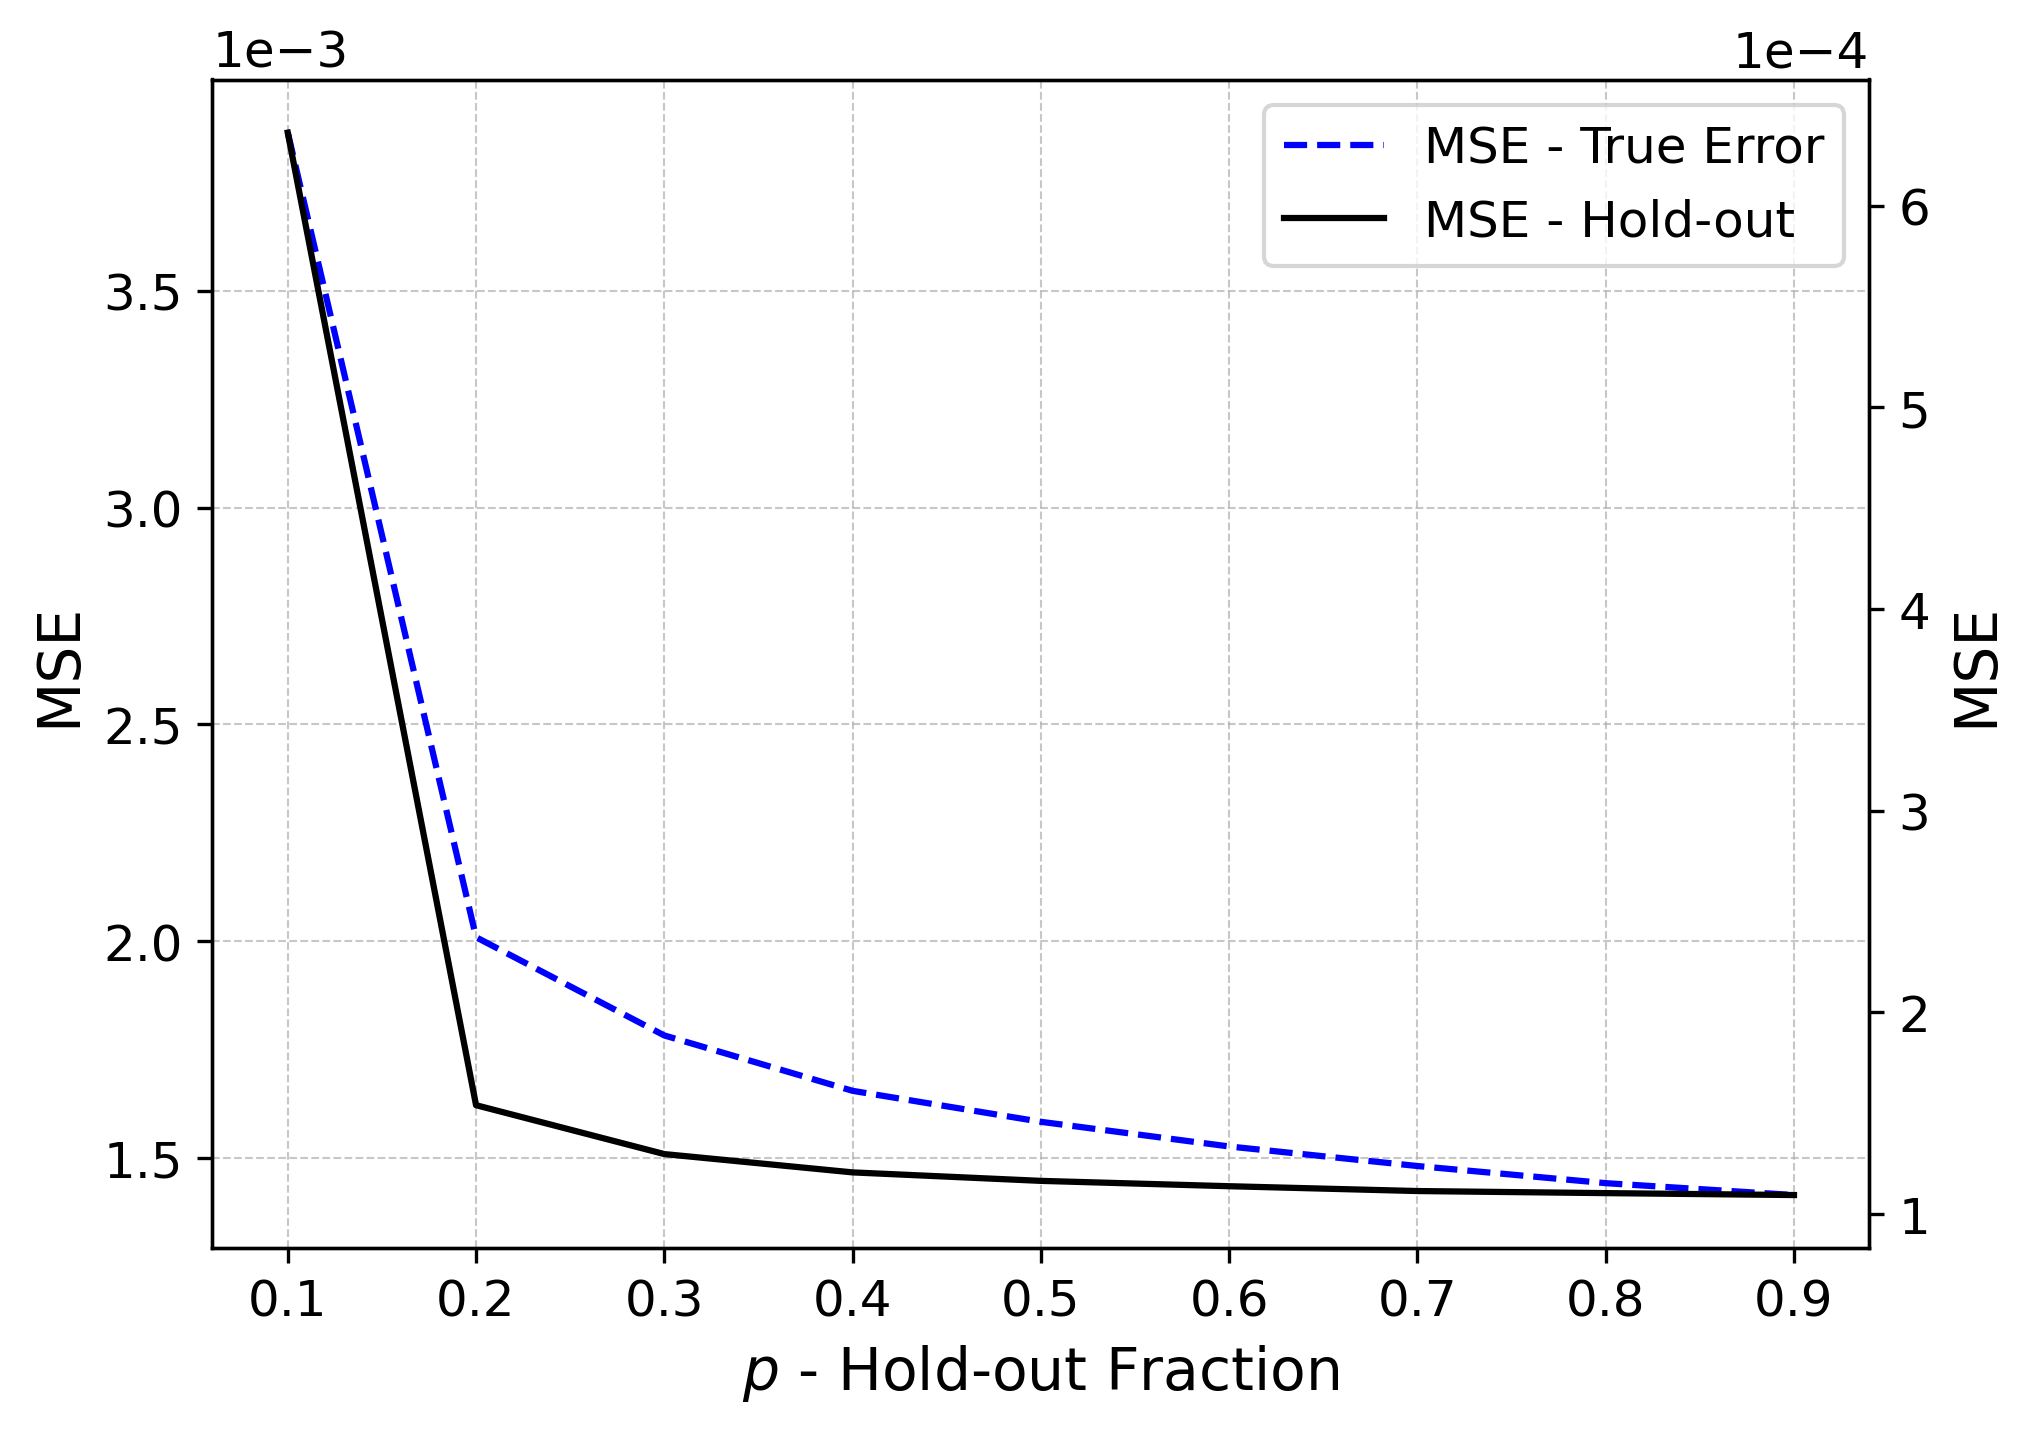

In [13]:
import matplotlib.pyplot as plt
from matplotlib import rc_context

true_sigma = 2.0

# Define your custom rc params
rc_params = {
    'figure.figsize':   (7, 5),
    'figure.dpi':       300,
    'font.size':        14,
    'axes.titlesize':   16,
    'axes.labelsize':   14,
    'xtick.labelsize':  12,
    'ytick.labelsize':  12,
    'legend.fontsize':  12,
    'lines.linewidth':  1.5,
    'lines.markersize': 5
}

# Wrap only this figure in the context
with rc_context(rc_params):
    fig, ax = plt.subplots()

    # Plot MSE curve
    ax.plot(records_df['k_p'],
            records_df['true_score'],
            linestyle='--', marker='',
            color='blue',
            label='MSE - True Error', zorder=2)

    ax2 = ax.twinx()

    ax2.plot(records_df['k_p'],
            records_df['cv_score'],
            linestyle='-', marker='',
            color='black',
            label='MSE - Hold-out', zorder=2)

    # Decorate
    ax.set_xlabel('$p$ - Hold-out Fraction')
    ax.set_ylabel('MSE')

    ax2.set_ylabel('MSE')
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)

    ax.ticklabel_format(axis="y", style='sci', scilimits=(1e1,1e2))
    ax2.ticklabel_format(axis="y", style='sci', scilimits=(1e1,1e2))
    
    plt.tight_layout()

    plt.savefig("holdout_p_curve.pdf")
    
    plt.show()

In [14]:
import itertools
import pandas as pd
from skimage import data, color
import numpy as np
from scipy.signal import convolve2d as sp_convolve2d

rng = np.random.default_rng(seed=0)
mask_p = 0.8
kernel_size = 19
kernel_sigma = 2
noise_sigma = 0.01

# Get PSF
P = psf_gaussian(kernel_size, kernel_sigma)

# # Load image
skim = data.astronaut()
X_true = color.rgb2gray(skim).astype(np.float64)

# Make corrupted image
X_conv = sp_convolve2d(X_true, P, mode='same', boundary='symm')
X_obs = X_conv + noise_sigma*rng.standard_normal(X_conv.shape)

sample_mask = (rng.random(X_true.shape)).astype(np.float64)


p_range = np.arange(0.1, 1, 0.1)
est_kernel_sigma_range = np.arange(1, 3+0.25, 0.25)

param_list = list(itertools.product(p_range, est_kernel_sigma_range))

tasks = [
    (k_p, k_sigma)
    for i, (k_p, k_sigma) in enumerate(param_list)
]

def worker(args):
    k_p = args[0]
    k_sigma = args[1]

    good_mask = (sample_mask < k_p).astype(np.float64)

    k_P = psf_gaussian(kernel_size, k_sigma)
    
    # Fit
    restored = fit(X_obs, k_P, good_mask, lam=0.00000215443469003188223619810714, warm_start=True)
    
    return {
        "k_p": k_p,
        "k_sigma": k_sigma,
        "cv_score": score(X_obs, k_P, restored, good_mask),
        "true_score": np.mean((X_true-restored)**2)
    }

results = map(worker, tasks)

records_df = pd.DataFrame(results)

Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 598
Converged (rel‐tol) at iter 745
Converged (rel‐tol) at iter 895
Converged (rel‐tol) at iter 1032
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 188
Converged (rel‐tol) at iter 260
Converged (rel‐tol) at iter 353
Converged (rel‐tol) at iter 477
Converged (rel‐tol) at iter 635
Converged (rel‐tol) at iter 812
Converged (rel‐tol) at iter 993
Converged (rel‐tol) at iter 1149
Converged (rel‐tol) at iter 131
Converged (rel‐tol) at iter 184
Converged (rel‐tol) at iter 254
Converged (rel‐tol) at iter 343
Converged (rel‐tol) at iter 470
Converged (rel‐tol) at iter 644
Converged (rel‐tol) at iter 839
Converged (rel‐tol) at iter 1047
Converged (rel‐tol) at iter 1211
Converged (rel‐tol) at iter 132
Converged (rel‐tol) at iter 181
Converged (rel‐tol) at iter 247
Converged (rel‐tol) at iter 336
Converged 

In [30]:
import itertools
import pandas as pd
from skimage import data, color
import numpy as np
from scipy.signal import convolve2d as sp_convolve2d

# --- Setup ---
rng = np.random.default_rng(seed=0)
mask_p = 0.8
kernel_size = 19
kernel_sigma = 2
noise_sigma = 0.01
n_replicates = 5  # Number of replicates per parameter combination

# Get PSF
P = psf_gaussian(kernel_size, kernel_sigma)

# Load image
skim = data.astronaut()
X_true = color.rgb2gray(skim).astype(np.float64)

# Corrupt image
X_conv = sp_convolve2d(X_true, P, mode='same', boundary='symm')
X_obs = X_conv + noise_sigma * rng.standard_normal(X_conv.shape)

# Parameter ranges
p_range = np.arange(0.1, 1, 0.1)
est_kernel_sigma_range = np.arange(1, 3.25, 0.25)

# Create all tasks with replicates
param_list = list(itertools.product(p_range, est_kernel_sigma_range, range(n_replicates)))

def worker(args):
    k_p, k_sigma, rep = args

    # Independent RNG for each replicate
    local_rng = np.random.default_rng(seed=rep + int(k_p*1000) + int(k_sigma*1000))

    sample_mask = local_rng.random(X_true.shape)
    good_mask = (sample_mask < k_p).astype(np.float64)

    k_P = psf_gaussian(kernel_size, k_sigma)

    # Fit model
    restored = fit(X_obs, k_P, good_mask, lam=2.15443469003188223619810714e-6, warm_start=True)

    return {
        "k_p": k_p,
        "k_sigma": k_sigma,
        "replicate": rep,
        "cv_score": score(X_obs, k_P, restored, good_mask),
        "true_score": np.mean((X_true - restored) ** 2)
    }

# Run tasks
results = map(worker, param_list)
records_df = pd.DataFrame(results)

Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 50
Converged (rel‐tol) at iter 466
Converged (rel‐tol) at iter 463
Converged (rel‐tol) at iter 466
Converged (rel‐tol) at iter 467
Converged (rel‐tol) at iter 465
Converged (rel‐tol) at iter 599
Converged (rel‐tol) at iter 603
Converged (rel‐tol) at iter 602
Converged (rel‐tol) at iter 599
Converged (rel‐tol) at iter 585
Converged (rel‐tol) at iter 745
Converged (rel‐tol) at iter 

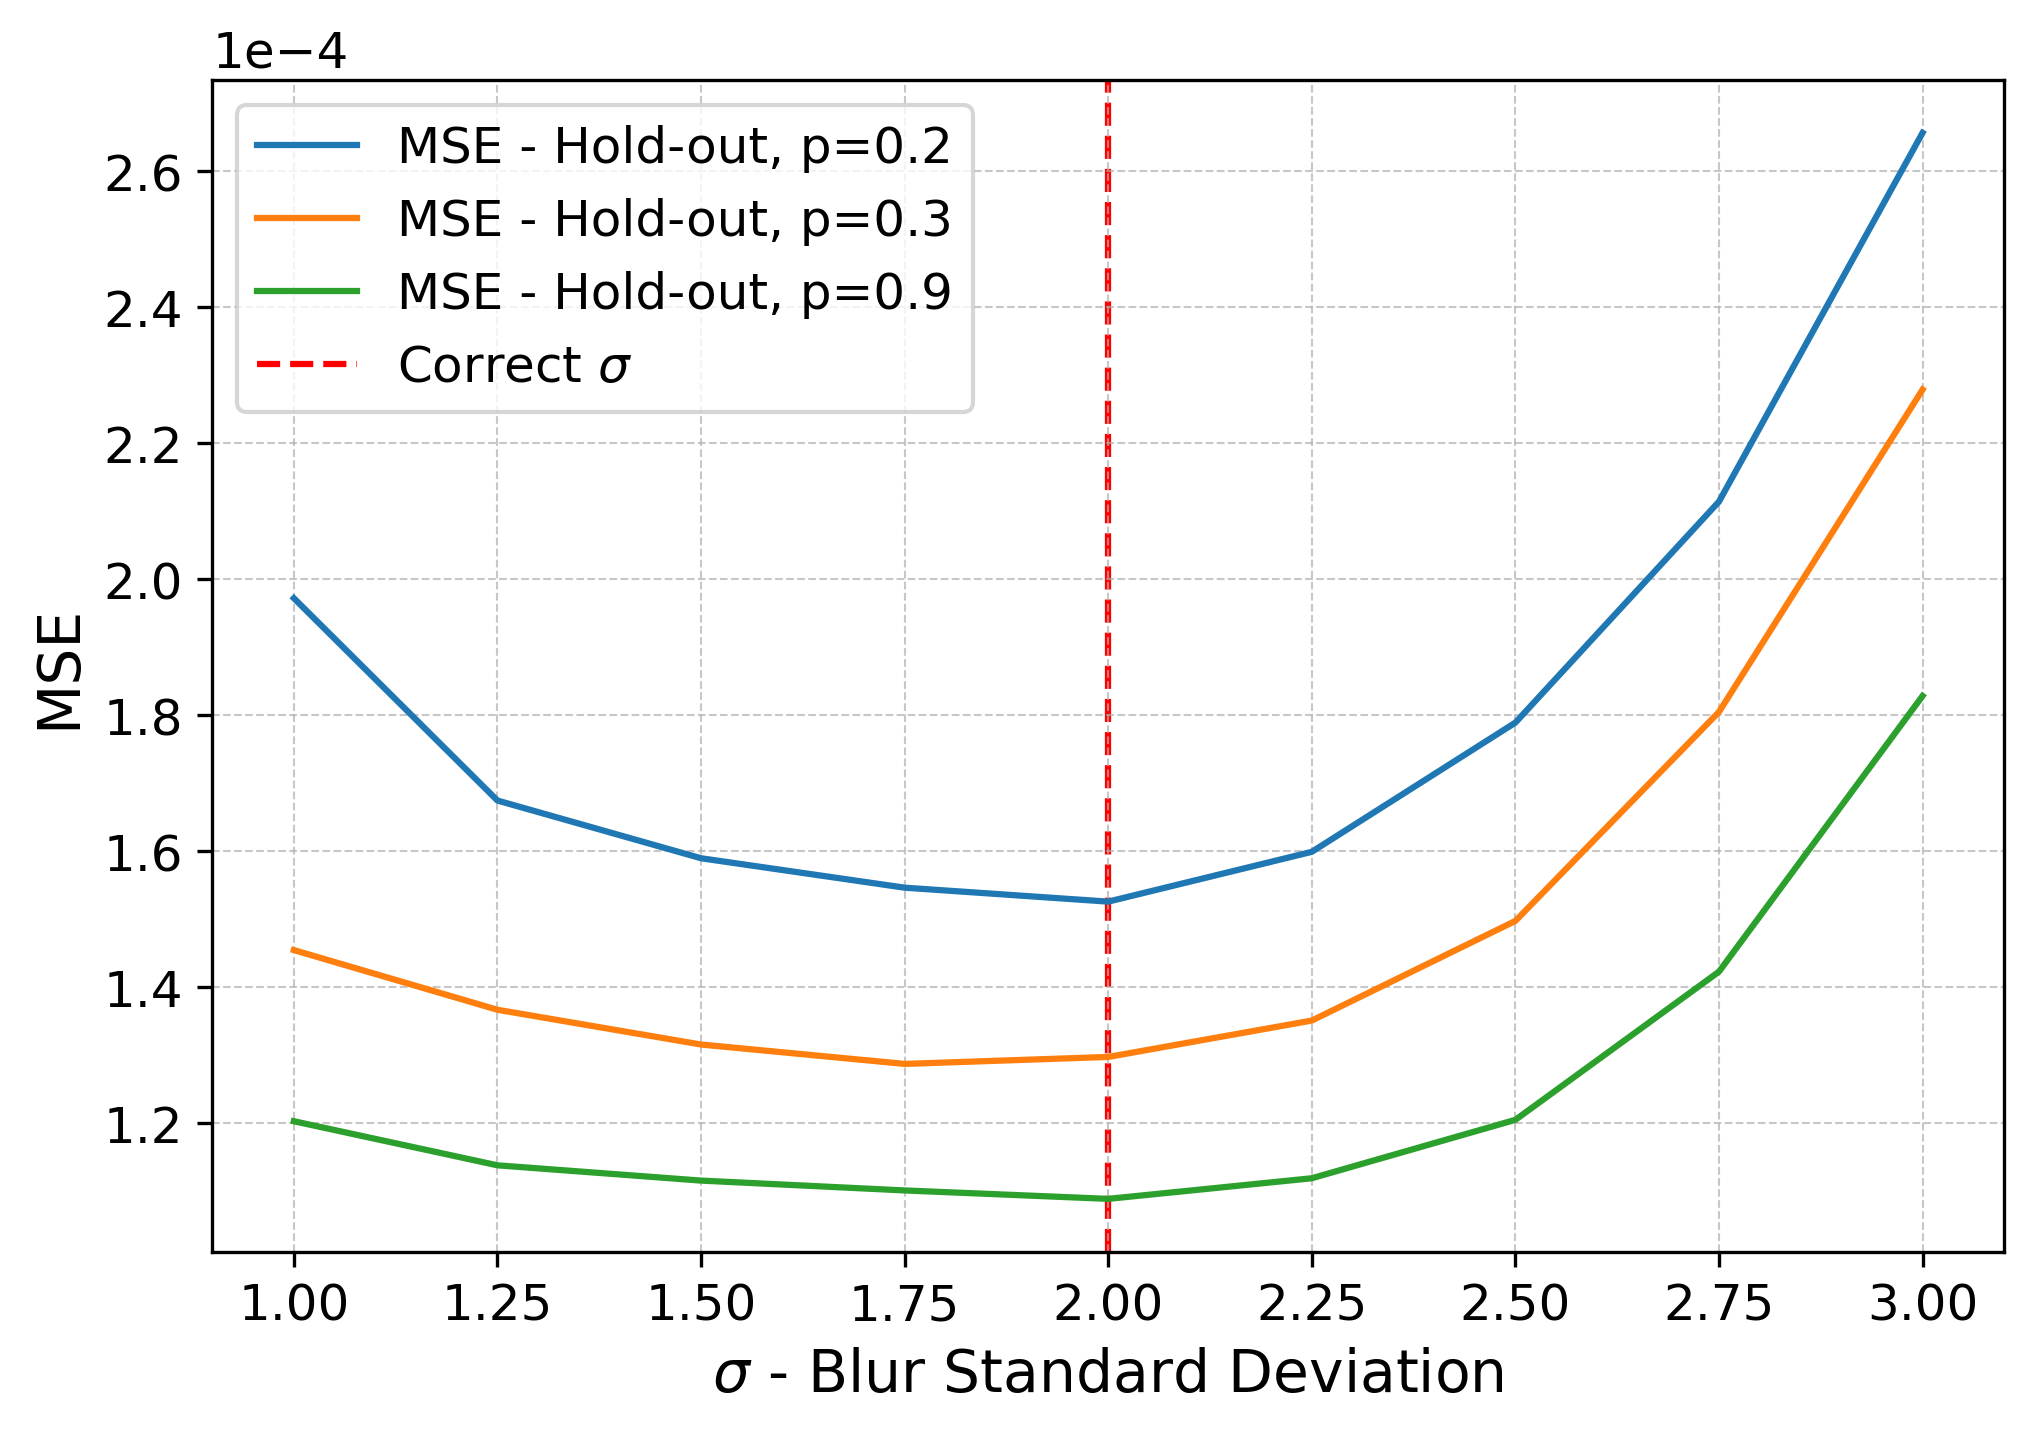

In [75]:
import matplotlib.pyplot as plt
from matplotlib import rc_context

# Estimated optimum
best_cv_idx   = records_df['cv_score'].idxmin()
best_cv_sigma = records_df.loc[best_cv_idx, 'k_sigma']
best_cv_score = records_df.loc[best_cv_idx, 'cv_score']

best_idx   = records_df['true_score'].idxmin()
best_sigma = records_df.loc[best_idx, 'k_sigma']
best_score = records_df.loc[best_idx, 'true_score']

true_sigma = 2.0

# Define your custom rc params
rc_params = {
    'figure.figsize':   (7, 5),
    'figure.dpi':       300,
    'font.size':        14,
    'axes.titlesize':   16,
    'axes.labelsize':   14,
    'xtick.labelsize':  12,
    'ytick.labelsize':  12,
    'legend.fontsize':  12,
    'lines.linewidth':  1.5,
    'lines.markersize': 5
}

# Wrap only this figure in the context
with rc_context(rc_params):
    fig, ax = plt.subplots()

    for p in [p_range[1], p_range[2], p_range[8]]:
        k_group = records_df.query("k_p == @p").groupby("k_sigma").mean().reset_index()
        
        # Plot MSE curve
        ax.plot(k_group['k_sigma'],
                k_group['cv_score'],
                linestyle='-', marker='',
                # color='black',
                label=f'MSE - Hold-out, p={p:0.1f}', zorder=2)

    ax.axvline(x=2, ymin=0, ymax=100, zorder=0, linestyle='--', color='red', label="Correct $\sigma$")
    
    # Decorate
    ax.set_xlabel('$\sigma$ - Blur Standard Deviation')
    ax.set_ylabel('MSE')
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    ax.legend()
    
    ax.ticklabel_format(axis="y", style='sci', scilimits=(1e1,1e2))
    
    plt.tight_layout()

    plt.savefig("holdout_sigma_holdout.pdf")
    
    plt.show()

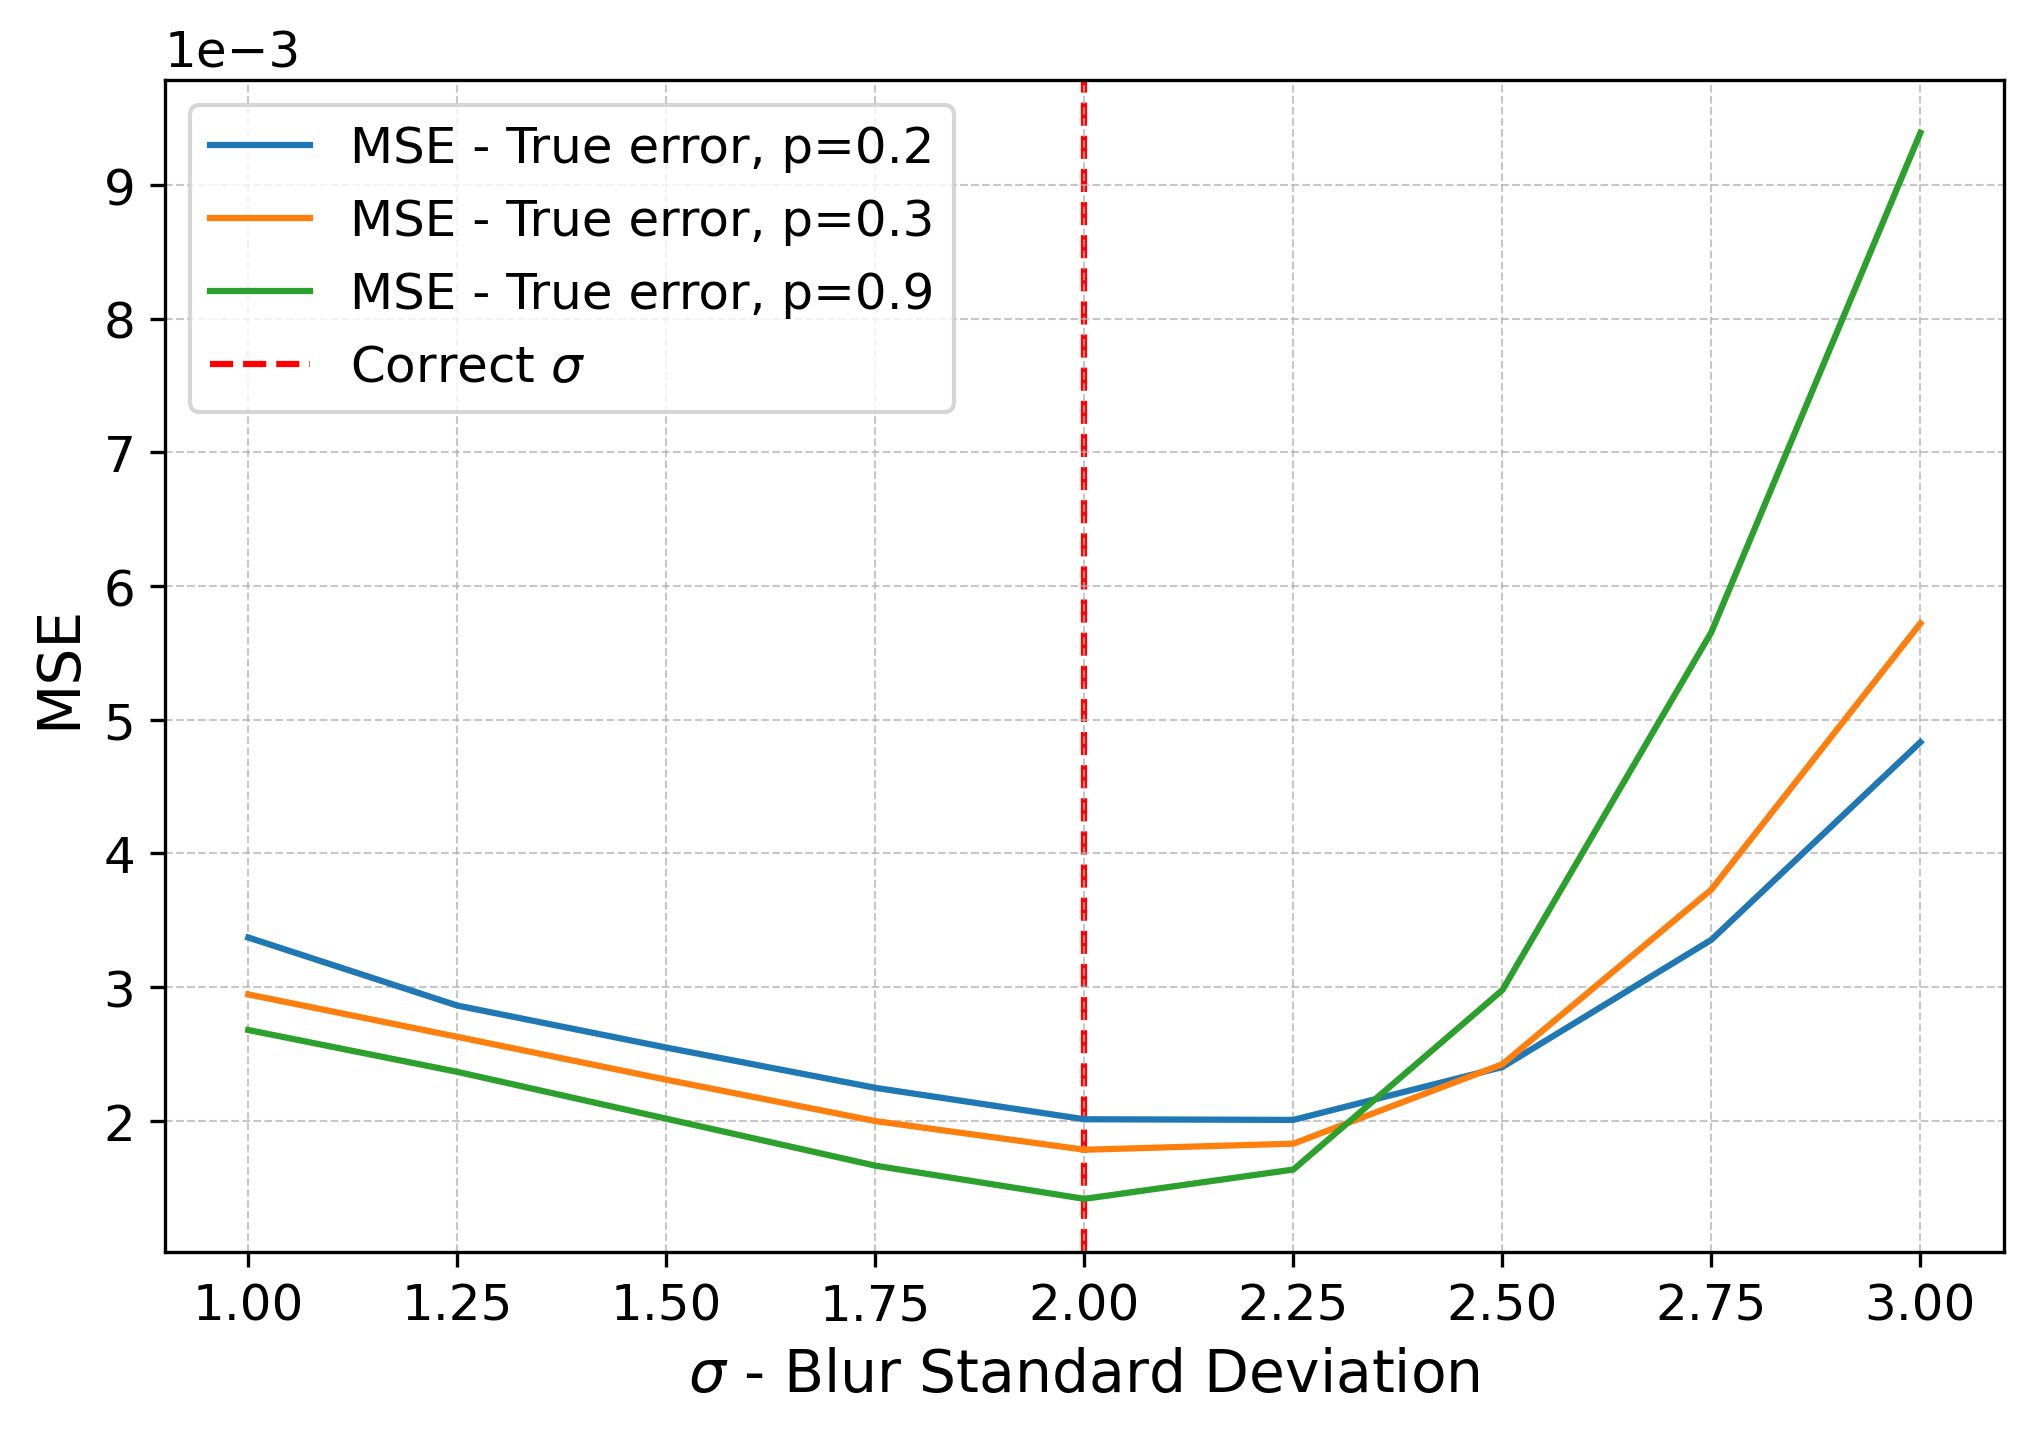

In [74]:
import matplotlib.pyplot as plt
from matplotlib import rc_context

# Estimated optimum
best_cv_idx   = records_df['cv_score'].idxmin()
best_cv_sigma = records_df.loc[best_cv_idx, 'k_sigma']
best_cv_score = records_df.loc[best_cv_idx, 'cv_score']

best_idx   = records_df['true_score'].idxmin()
best_sigma = records_df.loc[best_idx, 'k_sigma']
best_score = records_df.loc[best_idx, 'true_score']

true_sigma = 2.0

# Define your custom rc params
rc_params = {
    'figure.figsize':   (7, 5),
    'figure.dpi':       300,
    'font.size':        14,
    'axes.titlesize':   16,
    'axes.labelsize':   14,
    'xtick.labelsize':  12,
    'ytick.labelsize':  12,
    'legend.fontsize':  12,
    'lines.linewidth':  1.5,
    'lines.markersize': 5
}

# Wrap only this figure in the context
with rc_context(rc_params):
    fig, ax = plt.subplots()

    for p in [p_range[1], p_range[2], p_range[8]]:
        k_group = records_df.query("k_p == @p").groupby("k_sigma").mean().reset_index()
        
        # Plot MSE curve
        ax.plot(k_group['k_sigma'],
                k_group['true_score'],
                label=f'MSE - True error, p={p:0.1f}', zorder=2)


    ax.axvline(x=2, ymin=0, ymax=100, zorder=0, linestyle='--', color='red', label="Correct $\sigma$")
    
    # Decorate
    ax.set_xlabel('$\sigma$ - Blur Standard Deviation')
    ax.set_ylabel('MSE')
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    ax.legend()
    
    ax.ticklabel_format(axis="y", style='sci', scilimits=(1e1,1e2))
    
    plt.tight_layout()

    plt.savefig("holdout_sigma_true.pdf")
    
    plt.show()